---
title: "A/B Testing Analysis"
author: Daniel Redel
date: "2024-04-05"
categories: [Causal Inference, A/B Testing, Python]
image: "abtest.png"
toc: true
format:
  html:
    toc: true
    code-fold: false
    html-math-method: katex
jupyter: python3
freeze: true
---

A/B testing Analysis using Python.

As data scientists, we are frequently confronted with questions like: **“Does $X$ affects $Y$?”** Here, $Y$ is the outcome that we care about, while $X$ could be a new feature, product, policy or experience. For example, a website owner would like to ask if a new web page design leads to a higher click-through rate or sale. Similarly, [Spotify](https://confidence.spotify.com/blog/ab-tests-and-rollouts) may  to know whether their new interface leads to more minutes of music played, while [Zalando](https://engineering.zalando.com/posts/2019/02/effectiveness-online-marketing.html) aims to assess the impact of their marketing actions on purchases.

But how do we go about answering such **causal questions**? For the Platform Economy, the solution **lies in experimentation**. By randomly assigning some kind of treatment (new interface design, new product, etc.) to a subset of users (Group A) and comparing their behavior or outcomes (such as revenue, visits, clicks, etc.) to those who did not receive the treatment (Group B), we can effectively isolate the causal impact of the change. This is at the core of **A/B testing** (also known as Randomized Control Trials), which is considered the workhorse method of experimentation for platforms like [Spotify](https://confidence.spotify.com/blog/experiment-like-spotify), [Uber](https://www.uber.com/en-NL/blog/xp/), [Netflix](https://netflixtechblog.com/what-is-an-a-b-test-b08cc1b57962), an more.

In this article, we will delve into the analysis involved in A/B testing using **Python**, with a specific focus on Randomization Checks and various methods or statistical tools for studying Average Treatment Effects. Let's go!

# Case Study: Online Wine Store's Email Campaign Experiment

As as study case, we are going to use an example taken from [Elea McDonnell](https://github.com/eleafeit/ab_test) (Drexel University). Imagine we are a _'Total Wine & More'_, a well established online wine store who wants to attract more customers and traffic to their website. Suppose our marketing team proposes launching an **email campaign** as a potential solution to drive more traffic and sales. However, before implementing the campaign, they want to conduct a test to determine which type of email design is more effective.

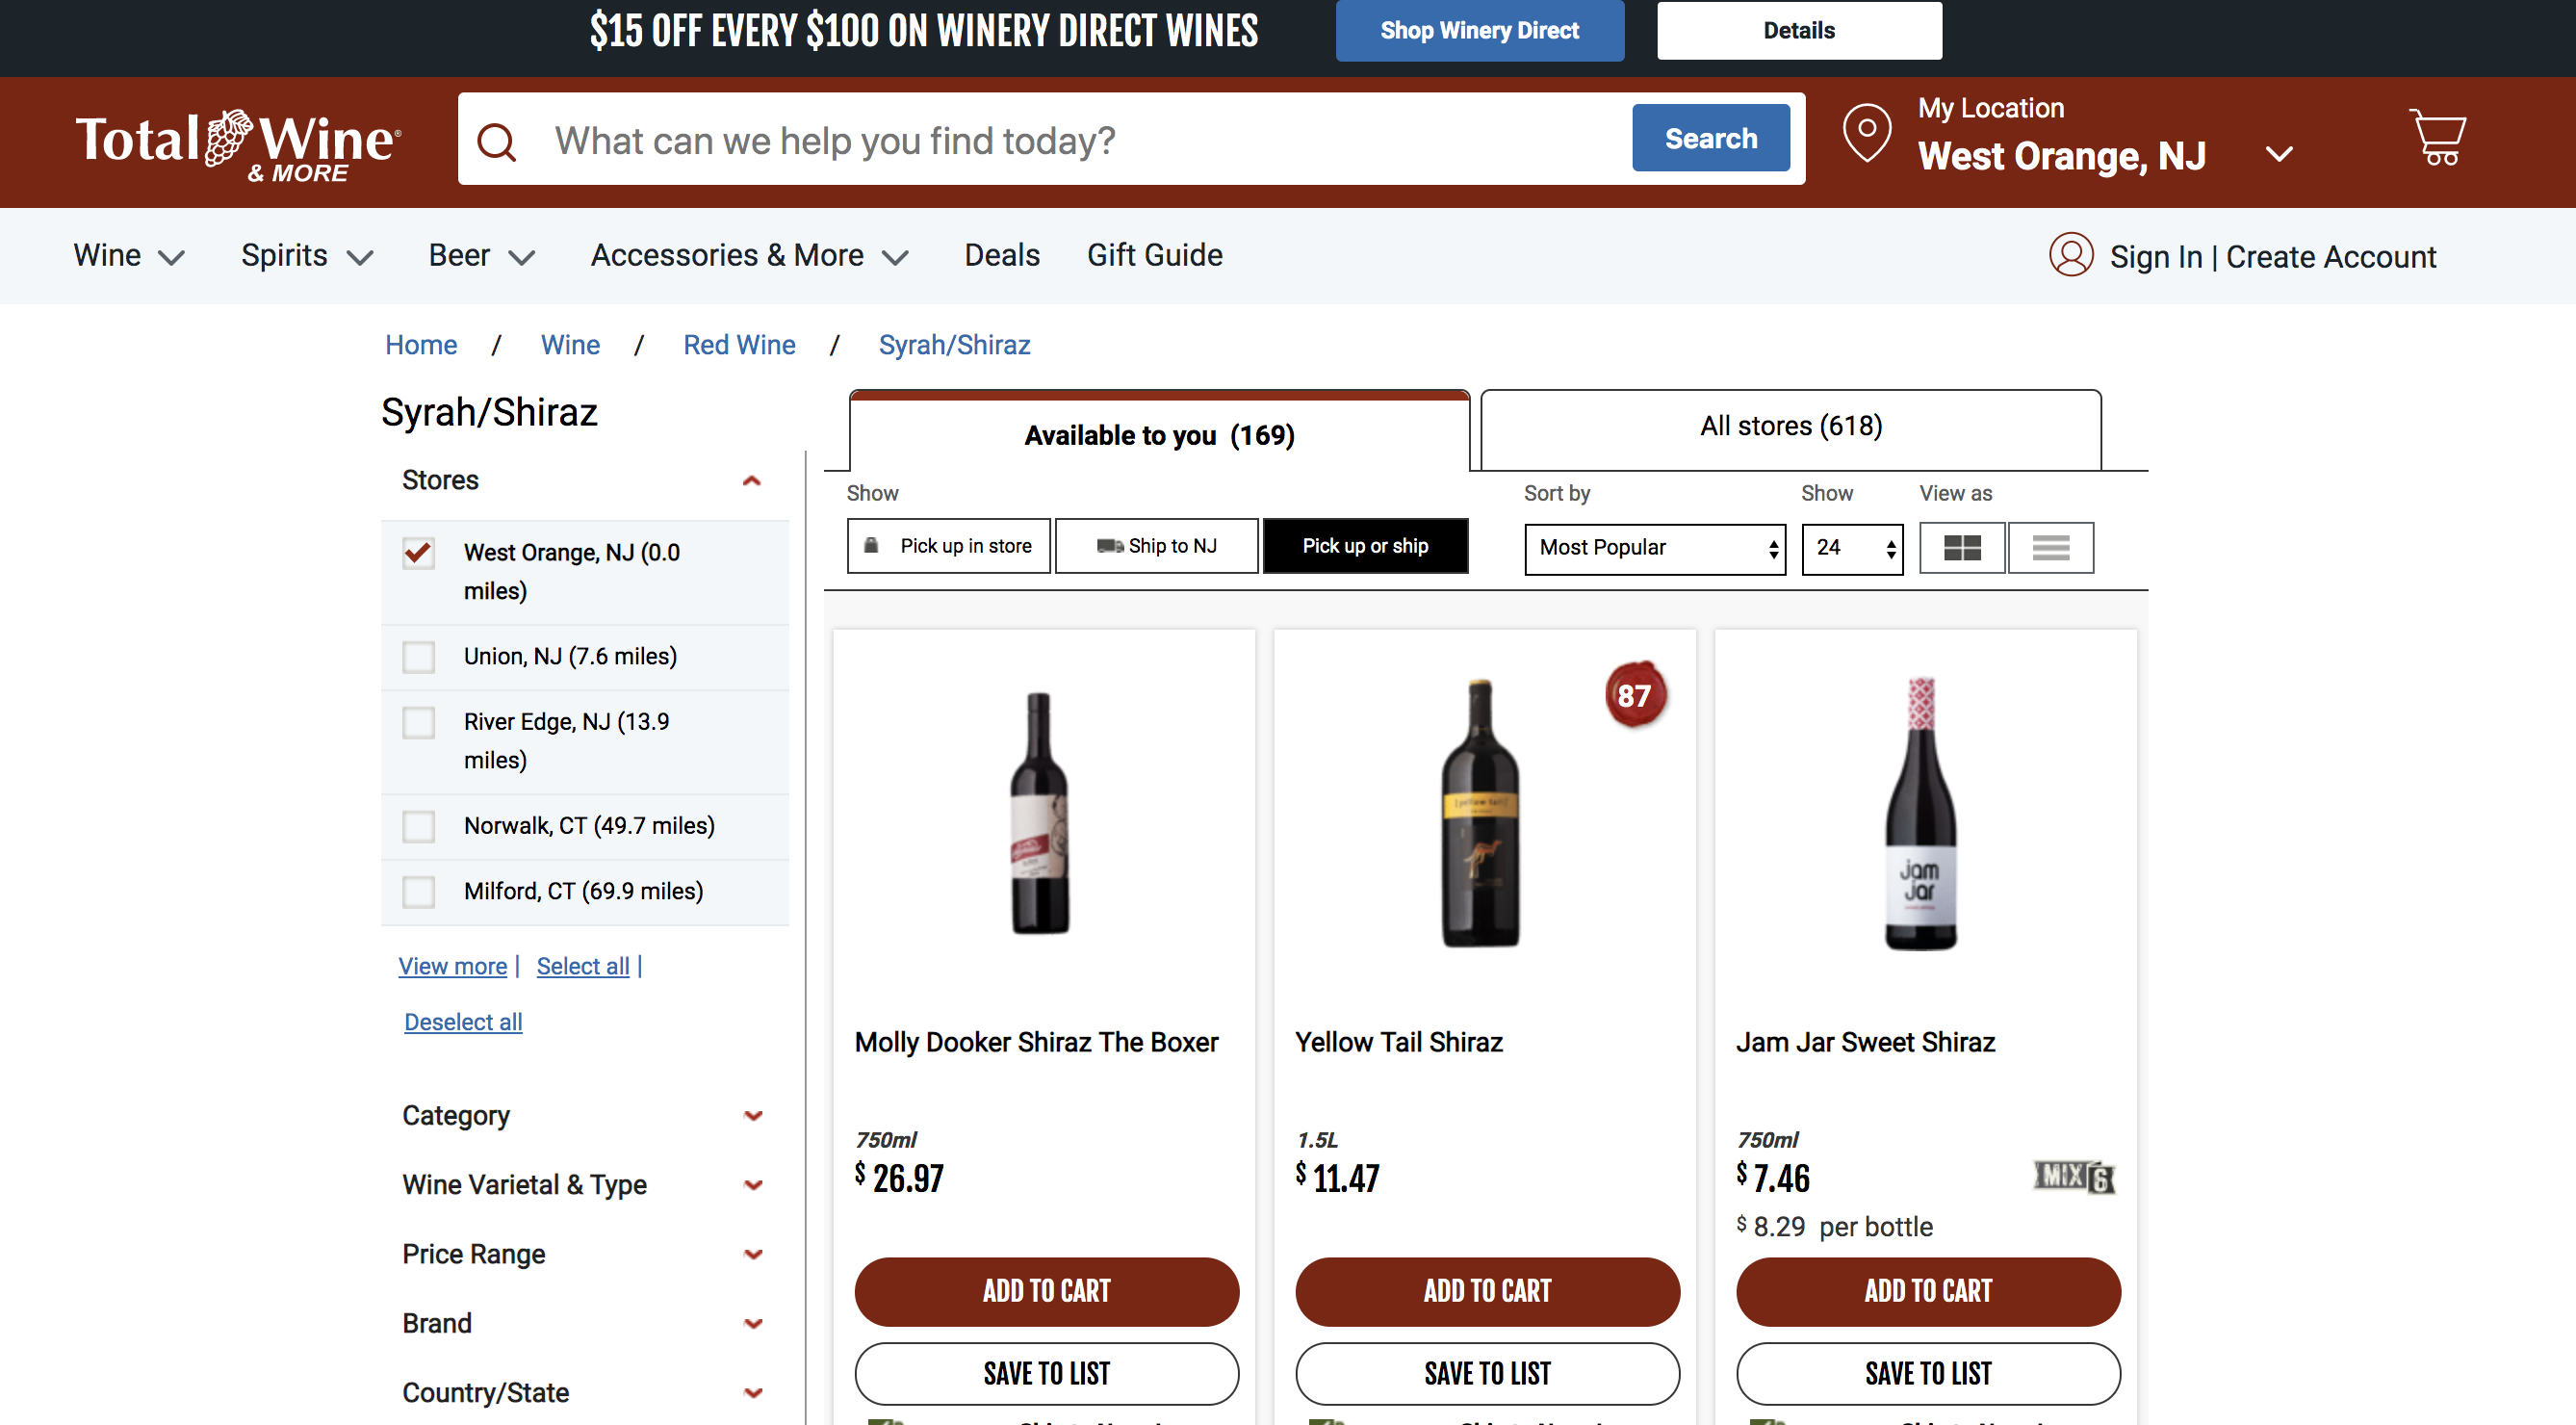

To evaluate the effectiveness of this email campaign, we conducted an **A/B test**. In this experiment, users were **randomly assigned** to one of three groups: one group received Email A, another group received Email B, and the remaining users were assigned to the control group, which did not receive any special email treatment. What's interesting here is that the design of the test enables us to address two main questions:

> 1. Does the email campaign lead to an increase in purchases compared to the control group (Treated vs. Control)?

> 2. Which email design is more effective in driving engagement and sales (Email A vs. Email B)?

@tbl-raw-dataset presents a sample of the dataset containing all the information we need to commence our analysis. The dataset can be found in [here](https://github.com/eleafeit/ab_test/blob/master/code/test_data.csv). 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis", 3)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#| label: tbl-raw-dataset
#| tbl-cap: Online Wine Store Dataset
#| code-fold: true

df = pd.read_csv('test_data.csv')
df.head()

,user_id,cpgn_id,group,email,open,click,purch,chard,sav_blanc,syrah,cab,past_purch,days_since,visits
0,1000001,1901Email,ctrl,False,0,0,0.00,0.00,0.00,33.94,0.00,33.94,119,11
1,1000002,1901Email,email_B,True,1,0,0.00,0.00,0.00,16.23,76.31,92.54,60,3
2,1000003,1901Email,email_A,True,1,1,200.51,516.39,0.00,16.63,0.00,533.02,9,9
3,1000004,1901Email,email_A,True,1,0,0.00,0.00,0.00,0.00,41.21,41.21,195,6
4,1000005,1901Email,email_A,True,1,1,158.30,426.53,1222.48,0.00,0.00,1649.01,48,9


A quick summary of what we have in this dataset:

- **Treatments**: The dataset includes three groups defined by the `group` variable: email version A, email version B, and holdout (control group).
- **Unit**: Each `user_id` unit in the dataset represents an email address.
- **Reponse Variables**: We are interested in study causal effects on 3 response variables:
  - `open`: Whether the recipient opened the test email (loaded images).
  - `click`: Whether the recipient clicked on the test email to visit the website.
  - `purch`: The amount ($) of purchases made within 30 days after the email was sent.
- **Selection**: The dataset consists of data from all active customers.
- **Assignment**: Participants were randomly assigned to one of the three groups (each group comprising one-third of the total sample).


# 1. Randomization Checks

Before assessing causal effects, it's crucial to ensure that the randomization process was executed correctly. Randomization ensures that, on average, the only difference between the two groups is the treatment, allowing us to attribute outcome differences to the treatment effect.

The reality is that, despite randomization, the two groups are never identical. Therefore, it's essential, after randomization, to check whether all observed variables are balanced across groups and whether there are no systematic differences.

**Randomization checks** serve to confirm **whether baseline variables are distributed similarly across the treatment and control groups**. In our case, referring back to @tbl-raw-dataset, the baseline variables of interest include:

- `days_since`: Days since last activity
- `visits`: Number of website visits
- `past_purch`: Total past purchases ($)
- Total _past_ purchases by category ($): `chard`, `sav_blanc`, `syrah`, `cab`

Let's just compare their means by treatment group:

In [75]:
#| label: tbl-baseline1
#| tbl-cap: Summary Statistics, by Group
#| echo: false

# Averages of baseline variables by treatment group
df[['days_since', 'visits', 'past_purch', 'chard', 'sav_blanc', 'syrah', 'cab', 'group']].groupby('group').mean().round(2).reset_index()

,group,days_since,visits,past_purch,chard,sav_blanc,syrah,cab
0,ctrl,89.98,5.95,188.27,71.67,73.63,26.45,16.52
1,email_A,90.17,5.95,188.45,73.46,72.10,26.62,16.26
2,email_B,89.81,5.94,189.66,74.81,71.63,26.96,16.27


Just by comparing and checking their means in @tbl-baseline1, we can already say that the randomization process was successful. On average, users across all treatment groups exhibit similar behavior and characteristics, making them comparable in terms of visits, past purchases, and other relevant factors. 

However, we want to go further than just comparing means and also **compare distributions across treatments**. This will ensure a balanced distribution of baseline variables among the treatment and control groups. We'll explore different methods to compare distributions and assess the magnitude and significance of their differences. We'll consider two approaches: **visual** and **statistical**. 

## 1.1. Violinplots

A first visual approach is the [**violinplot**](https://en.wikipedia.org/wiki/Violin_plot). The violinplot plots depicts distributions of numeric data for one or more groups using [**density curves**](https://math.libretexts.org/Bookshelves/Applied_Mathematics/Math_For_Liberal_Art_Students_2e_(Diaz)/11%3A_Normal_Distribution/11.02%3A_The_Density_Curve_of_a_Normal_Distribution#:~:text=A%20density%20curve%20is%20an,the%20most%20useful%20to%20us.). These densities —usually smoothed by a [**kernel density estimator**](https://en.wikipedia.org/wiki/Kernel_density_estimation)— are displayed along the `y-axis` so that we can compare them. By default, the `.violintplot()` function from the `seaborn` library also adds a miniature boxplot inside. @fig-violinplots shows the violinplots of our baseline variables:

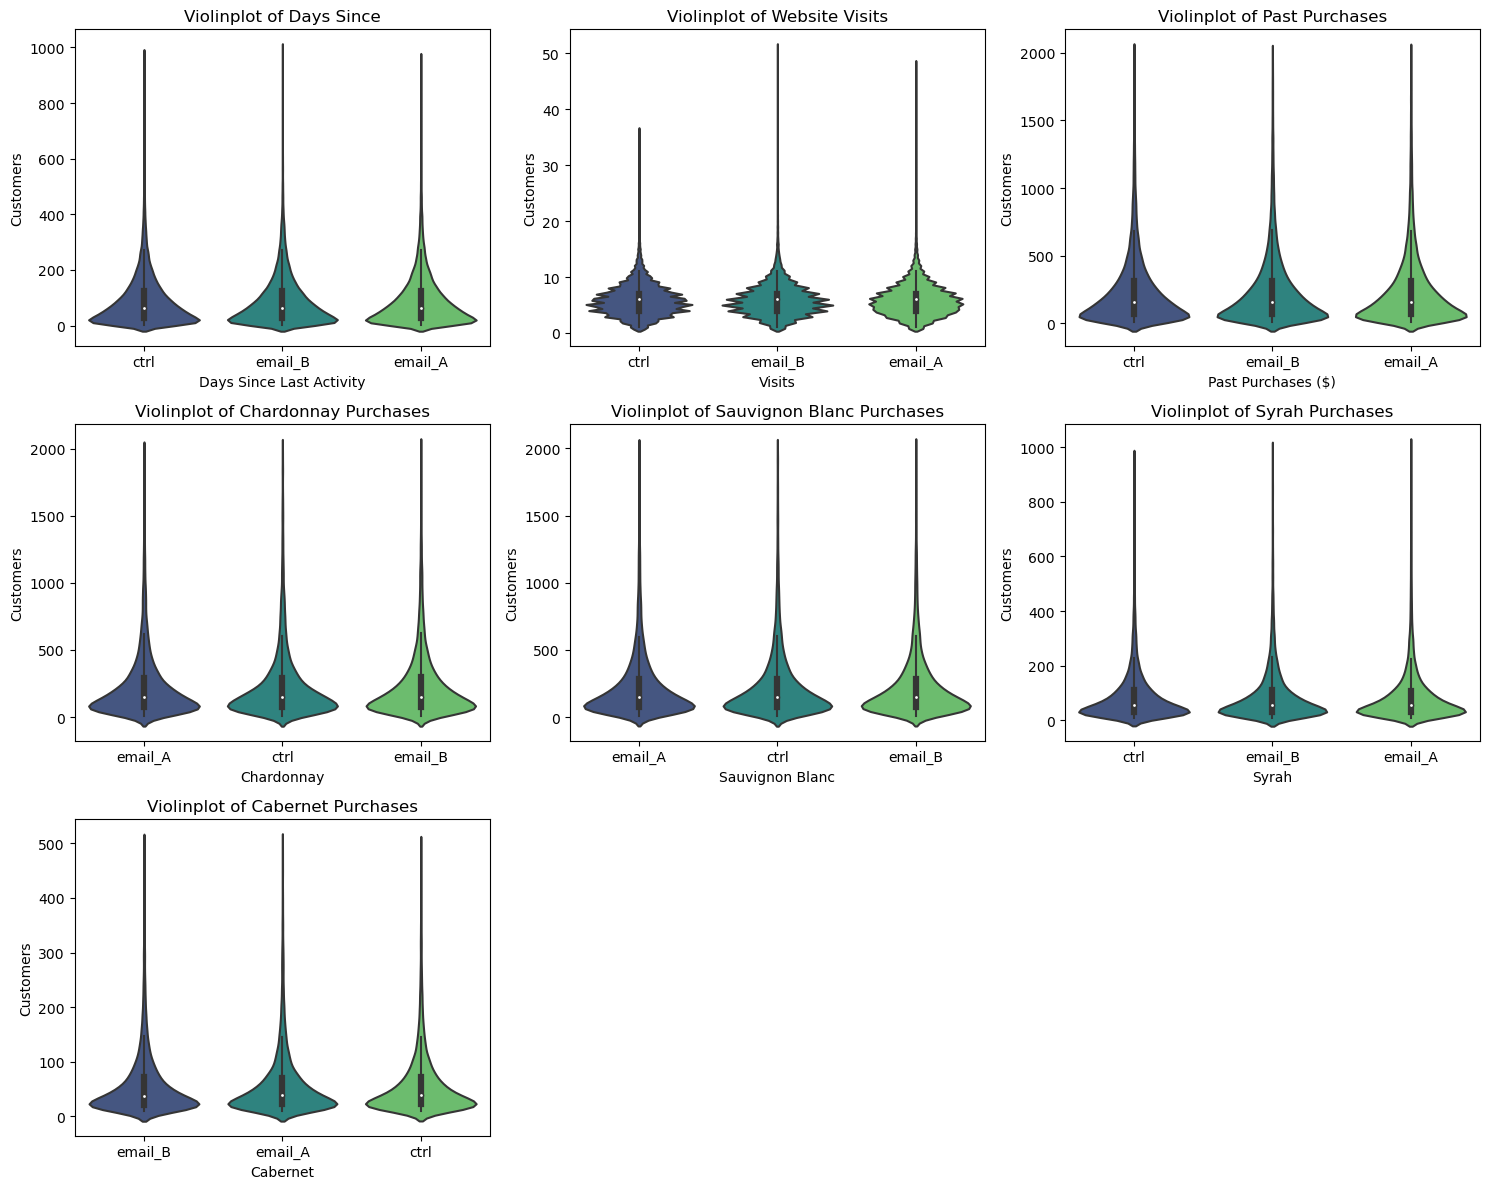

In [31]:
#| label: fig-violinplots
#| fig-cap: Violinplot of Baseline Variables
#| code-fold: true

import seaborn as sns
import matplotlib.pyplot as plt


# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

# Plot histogram for 'days_since'
filtered_df = df[df['days_since'] > 0]
sns.violinplot(data=filtered_df, x='group', y='days_since', palette='viridis', ax=axs[0, 0])
axs[0, 0].set_xlabel('Days Since Last Activity')
axs[0, 0].set_ylabel('Customers')
axs[0, 0].set_title('Violinplot of Days Since')

# Plot histogram for 'visits'
filtered_df = df[df['visits'] > 0]
sns.violinplot(data=filtered_df, x='group', y='visits', palette='viridis', ax=axs[0, 1])
axs[0, 1].set_xlabel('Visits')
axs[0, 1].set_ylabel('Customers')
axs[0, 1].set_title('Violinplot of Website Visits')

# Plot histogram for 'past_purch'
filtered_df = df[(df['past_purch'] > 0) & (df['past_purch'] < 2000)]
sns.violinplot(data=filtered_df, x='group', y='past_purch', palette='viridis', ax=axs[0, 2])
axs[0, 2].set_xlabel('Past Purchases ($)')
axs[0, 2].set_ylabel('Customers')
axs[0, 2].set_title('Violinplot of Past Purchases')

# Plot histogram for 'chard'
filtered_df = df[(df['chard'] > 0) & (df['chard'] < 2000)]
sns.violinplot(data=filtered_df, x='group', y='chard', palette='viridis', ax=axs[1, 0])
axs[1, 0].set_xlabel('Chardonnay')
axs[1, 0].set_ylabel('Customers')
axs[1, 0].set_title('Violinplot of Chardonnay Purchases')

# Plot histogram for 'sav_blanc'
filtered_df = df[(df['sav_blanc'] > 0) & (df['sav_blanc'] < 2000)]
sns.violinplot(data=filtered_df, x='group', y='sav_blanc', palette='viridis', ax=axs[1, 1])
axs[1, 1].set_xlabel('Sauvignon Blanc')
axs[1, 1].set_ylabel('Customers')
axs[1, 1].set_title('Violinplot of Sauvignon Blanc Purchases')

# Plot histogram for 'syrah'
filtered_df = df[(df['syrah'] > 0) & (df['syrah'] < 1000)]
sns.violinplot(data=filtered_df, x='group', y='syrah', palette='viridis', ax=axs[1, 2])
axs[1, 2].set_xlabel('Syrah')
axs[1, 2].set_ylabel('Customers')
axs[1, 2].set_title('Violinplot of Syrah Purchases')

# Plot histogram for 'cab'
filtered_df = df[(df['cab'] > 0) & (df['cab'] < 500)]
sns.violinplot(data=filtered_df, x='group', y='cab', palette='viridis', ax=axs[2, 0])
axs[2, 0].set_xlabel('Cabernet')
axs[2, 0].set_ylabel('Customers')
axs[2, 0].set_title('Violinplot of Cabernet Purchases')

# Hide the empty subplots
axs[2, 1].axis('off')
axs[2, 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

The shape of the distributions across `group` is quite similar, indicating comparable distributions of baseline variables. This similarity confirms that the randomization process was successful in achieving balance between the treatment and control groups.

## 1.2. Histograms

Another intuitive way to plot a distribution is the **[histogram](https://en.wikipedia.org/wiki/Histogram)**. The histogram groups the data into equally wide **bins** and plots the number of observations within each bin.

The full distributions of baseline variables should also be the same between treatment groups in this case:

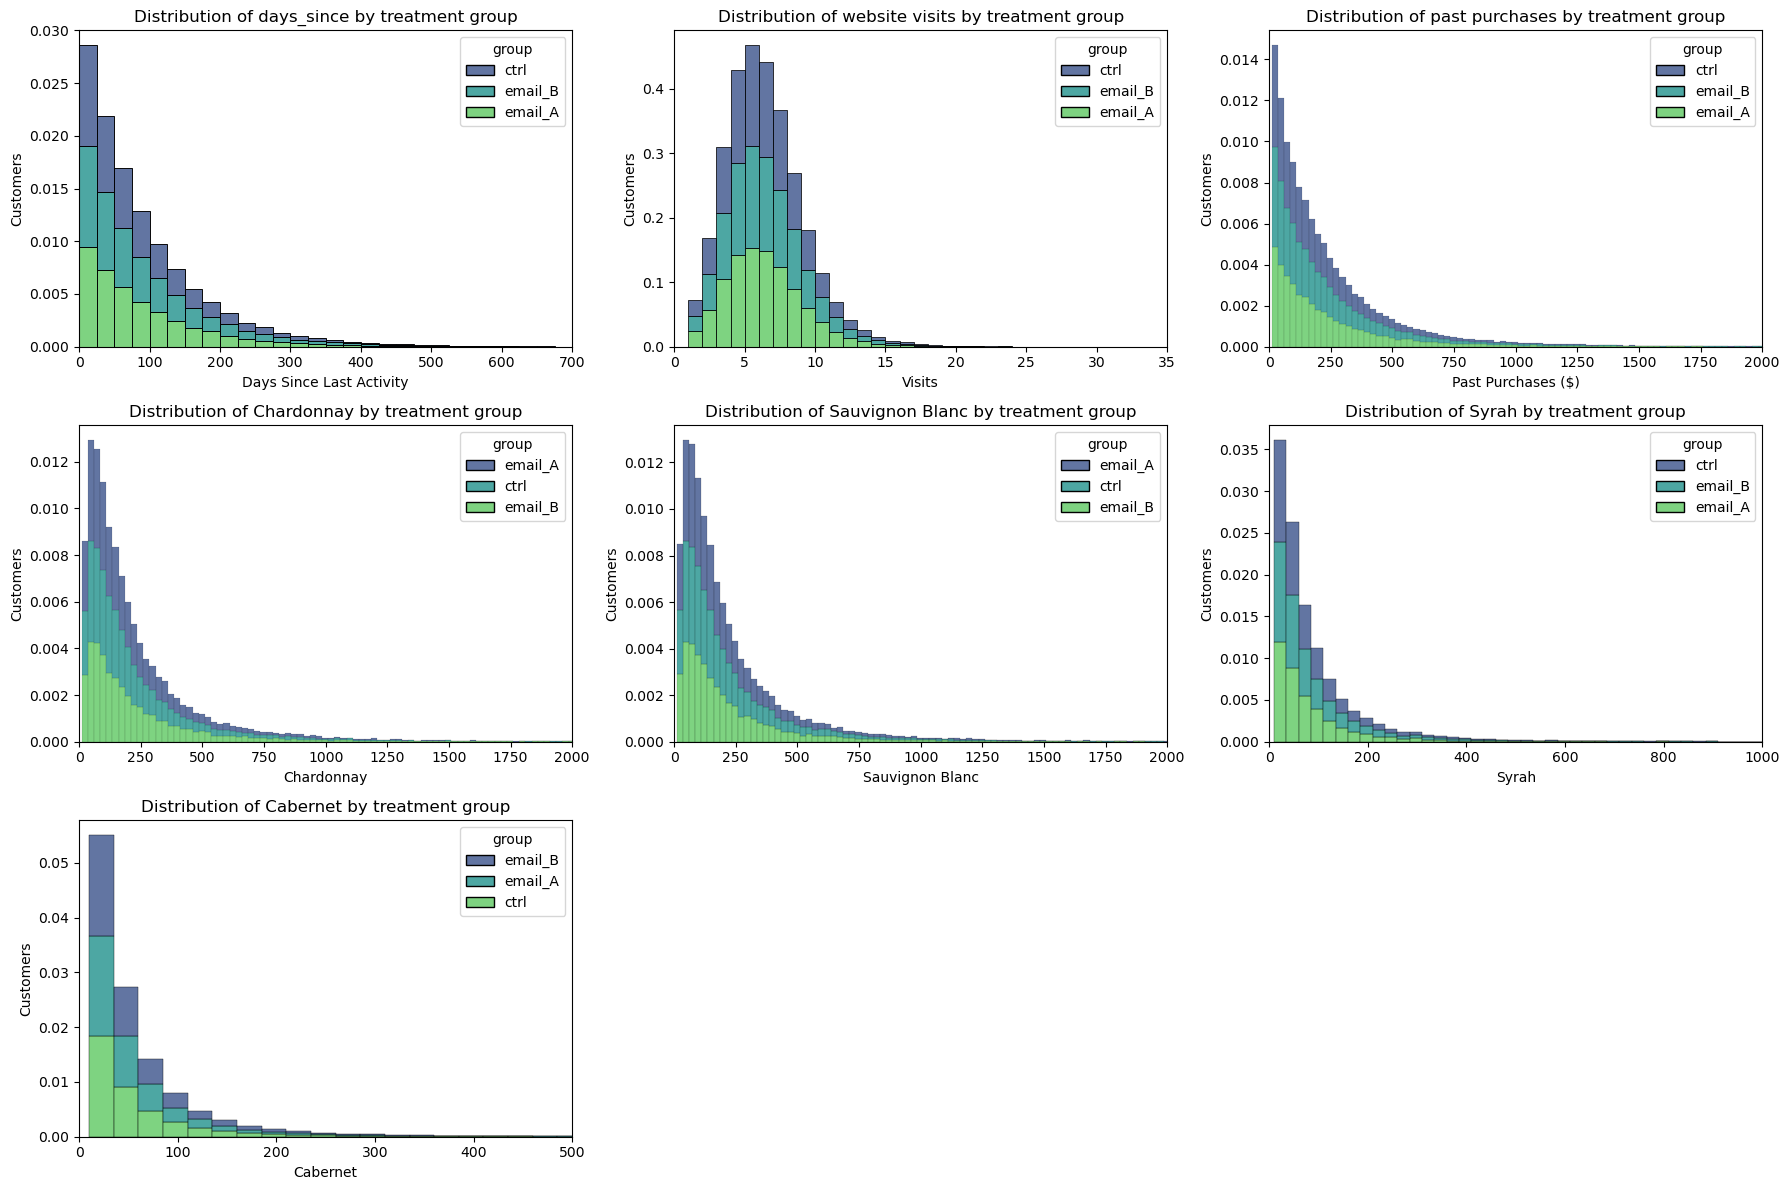

In [29]:
#| label: fig-hist
#| fig-cap: Histograms of Baseline Variables
#| code-fold: true

import seaborn as sns
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# Plot histogram for 'days_since'
sns.histplot(data=df, x='days_since', hue='group', binwidth=25, stat='density', common_norm=False, alpha=0.8, multiple='stack', palette='viridis', ax=axs[0, 0])
axs[0, 0].set_xlim(0, 700)
axs[0, 0].set_xlabel('Days Since Last Activity')
axs[0, 0].set_ylabel('Customers')
axs[0, 0].set_title('Distribution of days_since by treatment group')

# Plot histogram for 'visits'
filtered_df = df[df['visits'] > 0]
sns.histplot(data=filtered_df, x='visits', hue='group', binwidth=1, stat='density', common_norm=False, alpha=0.8, multiple='stack', palette='viridis', ax=axs[0, 1])
axs[0, 1].set_xlim(0, 35)
axs[0, 1].set_xlabel('Visits')
axs[0, 1].set_ylabel('Customers')
axs[0, 1].set_title('Distribution of website visits by treatment group')

# Plot histogram for 'past_purch'
filtered_df = df[df['past_purch'] > 0]
sns.histplot(data=filtered_df, x='past_purch', hue='group', binwidth=25, stat='density', common_norm=False, alpha=0.8, multiple='stack', palette='viridis', ax=axs[0, 2])
axs[0, 2].set_xlim(0, 2000)
axs[0, 2].set_xlabel('Past Purchases ($)')
axs[0, 2].set_ylabel('Customers')
axs[0, 2].set_title('Distribution of past purchases by treatment group')

# Plot histogram for 'chard'
filtered_df = df[df['chard'] > 0]
sns.histplot(data=filtered_df, x='chard', hue='group', binwidth=25, stat='density', common_norm=False, alpha=0.8, multiple='stack', palette='viridis', ax=axs[1, 0])
axs[1, 0].set_xlim(0, 2000)
axs[1, 0].set_xlabel('Chardonnay')
axs[1, 0].set_ylabel('Customers')
axs[1, 0].set_title('Distribution of Chardonnay by treatment group')

# Plot histogram for 'sav_blanc'
filtered_df = df[df['sav_blanc'] > 0]
sns.histplot(data=filtered_df, x='sav_blanc', hue='group', binwidth=25, stat='density', common_norm=False, alpha=0.8, multiple='stack', palette='viridis', ax=axs[1, 1])
axs[1, 1].set_xlim(0, 2000)
axs[1, 1].set_xlabel('Sauvignon Blanc')
axs[1, 1].set_ylabel('Customers')
axs[1, 1].set_title('Distribution of Sauvignon Blanc by treatment group')

# Plot histogram for 'syrah'
filtered_df = df[df['syrah'] > 0]
sns.histplot(data=filtered_df, x='syrah', hue='group', binwidth=25, stat='density', common_norm=False, alpha=0.8, multiple='stack', palette='viridis', ax=axs[1, 2])
axs[1, 2].set_xlim(0, 1000)
axs[1, 2].set_xlabel('Syrah')
axs[1, 2].set_ylabel('Customers')
axs[1, 2].set_title('Distribution of Syrah by treatment group')

# Plot histogram for 'cab'
filtered_df = df[df['cab'] > 0]
sns.histplot(data=filtered_df, x='cab', hue='group', binwidth=25, stat='density', common_norm=False, alpha=0.8, multiple='stack', palette='viridis', ax=axs[2, 0])
axs[2, 0].set_xlim(0, 500)
axs[2, 0].set_xlabel('Cabernet')
axs[2, 0].set_ylabel('Customers')
axs[2, 0].set_title('Distribution of Cabernet by treatment group')

# Hide empty subplots
for ax in axs.flat[7:]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


Randomization checks out again!

## 1.3. T-Tests

Now that we've visualized differences between distributions, let's move on to a more rigorous approach for _assessing statistical significance_. Visualization provides **intuition** by allowing us to visually inspect differences, but we also want to be able to quantify the significance of these differences.

The most common test is the [student t-test](https://en.wikipedia.org/wiki/Student%27s_t-test). T-tests are generally used to **compare means**. In this case, we want to test whether the means of the `days_since`, `visits` and `past_purch` distribution are the same across two groups: Treated (Email A + Email B) vs. Control. This test statistic is given by:

$$
stat = \frac{|\bar x_1 - \bar x_2|}{\sqrt{s^2 / n }}
$$

Where $\bar x$ is the sample mean and $s$ is the sample standard deviation. Under mild conditions, the test statistic is asymptotically distributed as a [student t](https://en.wikipedia.org/wiki/Student%27s_t-distribution) distribution.

We use the `ttest_ind` function from `scipy` to perform the t-test. The function returns both the test statistic and the implied [p-value](https://en.wikipedia.org/wiki/P-value).

In [3]:
from scipy.stats import ttest_ind

# Treated vs Control Categorical Variable
df['treat'] = df['group'].map({'email_A': 'treated', 'email_B': 'treated', 'ctrl': 'control'})

## Days Since
days_since_treated = df.loc[df.treat=='treated', 'days_since'].values
days_since_ctrl = df.loc[df.treat=='control', 'days_since'].values

stat, p_value = ttest_ind(days_since_treated, days_since_ctrl)
print(f"days_since t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

days_since t-test: statistic=0.0154, p-value=0.9877


In [4]:
#| echo: false

## Visits
visits_treated = df.loc[df.treat=='treated', 'visits'].values
visits_ctrl = df.loc[df.treat=='control', 'visits'].values

stat, p_value = ttest_ind(visits_treated, visits_ctrl)
print(f"visits t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

## Past Purchase
past_purch_treated = df.loc[df.treat=='treated', 'past_purch'].values
past_purch_ctrl = df.loc[df.treat=='control', 'past_purch'].values

stat, p_value = ttest_ind(past_purch_treated, past_purch_ctrl)
print(f"past_purch t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

visits t-test: statistic=-0.2451, p-value=0.8064
past_purch t-test: statistic=0.4345, p-value=0.6639


The p-values from these tests all are above 0.1, therefore we do **not reject** the null hypothesis of no difference in *means* across treatment and control groups.

The thing is, our example has m**ore than 2 groups to compare**. With multiple groups, the most popular test is the [**F-test**](https://en.wikipedia.org/wiki/F-test). The F-test compares the variance of a variable across different groups. The F-test statistic is

$$
\text{stat} = \frac{\text{between-group variance}}{\text{within-group variance}} = \frac{\sum_{g} \big( \bar x_g - \bar x \big) / (G-1)}{\sum_{g} \sum_{i \in g} \big( \bar x_i - \bar x_g \big) / (N-G)}
$$

Where $G$ is the number of groups, $N$ is the number of observations, $\bar x$ is the overall mean and $\bar x_g$ is the mean within group $g$. Under the null hypothesis of group independence, the f-statistic is [F-distributed](https://en.wikipedia.org/wiki/F-distribution).

In [5]:
from scipy.stats import f_oneway

# Days Since
days_since_A = df.loc[df.group=='email_A', 'days_since'].values
days_since_B = df.loc[df.group=='email_B', 'days_since'].values
days_since_ctrl = df.loc[df.group=='ctrl', 'days_since'].values

stat, p_value = f_oneway(days_since_A, days_since_B, days_since_ctrl)
print(f"days_since F-statistic={stat:.4f}, p-value={p_value:.4f}")

days_since F-statistic=0.1642, p-value=0.8485


In [6]:
#| echo: false

# Visits
visits_A = df.loc[df.group=='email_A', 'visits'].values
visits_B = df.loc[df.group=='email_B', 'visits'].values
visits_ctrl = df.loc[df.group=='ctrl', 'visits'].values
stat, p_value = f_oneway(visits_A, visits_B, visits_ctrl)
print(f"visits F-statistic={stat:.4f}, p-value={p_value:.4f}")

# Past Purchases
past_purch_A = df.loc[df.group=='email_A', 'past_purch'].values
past_purch_B = df.loc[df.group=='email_B', 'past_purch'].values
past_purch_ctrl = df.loc[df.group=='ctrl', 'past_purch'].values
stat, p_value = f_oneway(past_purch_A, past_purch_B, past_purch_ctrl)
print(f"past_purch F-statistic={stat:.4f}, p-value={p_value:.4f}")

visits F-statistic=0.0336, p-value=0.9670
past_purch F-statistic=0.2618, p-value=0.7697


Here again, the p-values are telling us that these distributions across treatment are likely similar.

## 1.4. Standardized Mean Difference

In general, it is good practice to always perform a test for difference in means on **all variables** across the treatment and control group, when we are running A/B tests. However, since the denominator of the t-test statistic depends on the sample size, the corresponding p-values are not directly comparable across studies. 

As alternative, we can use the **standardized mean difference (SMD)**, which is just a standardized difference, which can be computed as:

$$
SMD = \frac{|\bar x_1 - \bar x_2|}{\sqrt{(s^2_1 + s^2_2) / 2}}
$$

Usually a value below $0.1$ is considered a "small" difference. 

It is good practice to collect average values of all variables across treatment and control group and a measure of distance between the two — either the t-test or the SMD — into a table that is called **balance table**. 

Let's use the [`create_table_one`](https://causalml.readthedocs.io/en/latest/causalml.html#module-causalml.match) function from the [`causalml`](https://causalml.readthedocs.io/en/latest/about.html) library to generate it.

In [4]:
#| code-fold: true

import numpy as np
import pandas as pd

def smd(feature, treatment):
    """Calculate the standard mean difference (SMD) of a feature between the
    treatment and control groups.

    Args:
        feature (pandas.Series): a column of a feature to calculate SMD for
        treatment (pandas.Series): a column that indicate whether a row is in
                                   the treatment group or not

    Returns:
        (float): The SMD of the feature
    """
    t = feature[treatment == 1]
    c = feature[treatment == 0]
    return (t.mean() - c.mean()) / np.sqrt(0.5 * (t.var() + c.var()))



def create_table_one(data, treatment_col, features):
    """Report balance in input features between the treatment and control groups.

    Args:
        data (pandas.DataFrame): total or matched sample data
        treatment_col (str): the column name for the treatment
        features (list of str): the column names of features

    Returns:
        (pandas.DataFrame): A table with the means and standard deviations in
            the treatment and control groups, and the SMD between two groups
            for the features.
    """
    t1 = pd.pivot_table(
        data[features + [treatment_col]],
        columns=treatment_col,
        aggfunc=[lambda x: "{:.2f} ({:.2f})".format(x.mean(), x.std())],
    )
    t1.columns = t1.columns.droplevel(level=0)
    t1["SMD"] = data[features].apply(lambda x: smd(x, data[treatment_col])).round(4)

    n_row = pd.pivot_table(
        data[[features[0], treatment_col]], columns=treatment_col, aggfunc=["count"]
    )
    n_row.columns = n_row.columns.droplevel(level=0)
    n_row["SMD"] = ""
    n_row.index = ["n"]

    t1 = pd.concat([n_row, t1], axis=0)
    t1.columns.name = ""
    t1.columns = ["Control", "Treatment", "SMD"]
    t1.index.name = "Variable"

    return t1

In [5]:
#| label: tbl-balancetable
#| tbl-cap: Balance Table
df['treat'] = df['group'].map({'email_A': 1, 'email_B': 1, 'ctrl': 0})

create_table_one(df, 'treat', ['days_since', 'visits', 'past_purch', 'chard', 'sav_blanc', 'syrah', 'cab'])

,Control,Treatment,SMD
Variable,,,
n,41330,82658,
cab,16.52 (47.27),16.26 (46.67),-0.0053
chard,71.67 (199.39),74.14 (211.84),0.012
days_since,89.98 (89.50),89.99 (89.95),0.0001
past_purch,188.27 (298.18),189.06 (303.33),0.0026
sav_blanc,73.63 (203.37),71.87 (197.25),-0.0088
syrah,26.45 (73.91),26.79 (75.04),0.0045
visits,5.95 (2.85),5.94 (2.86),-0.0015


In the first two columns of @tbl-balancetable, we observe the average of the different variables across the treatment and control groups, with standard errors provided in parentheses. However, it's in the **last column** where the values of the standardized mean difference (SMD) are presented. A standardized difference below $|0.1|$ for all variables suggests that the two groups are likely similar.

# 2. Average Treatment Effects

Now, at last, we stand ready to estimate the effectiveness of our email campaign. Let's recall our main causal questions:

> 1. Does the email campaign lead to an increase in purchases (`purch`) compared to the control group (Treated vs. Control)?


In [3]:
#| label: tbl-ate-table
#| tbl-cap: Mean Response, by Treatment
#| echo: false

df['treat'] = df['group'].map({'email_A': 'treated', 'email_B': 'treated', 'ctrl': 'control'})

df[['open', 'click', 'purch', 'treat']].groupby('treat').mean().round(2).reset_index()

,treat,open,click,purch
0,control,0.00,0.00,12.42
1,treated,0.68,0.11,25.74


> 2. Which email design is more effective in driving engagement (`open`, `click`) and sales (`purch`) (Email A vs. Email B)?

In [7]:
#| label: tbl-ate-table1
#| tbl-cap: Mean Response, by Group
#| echo: false
df[['open', 'click', 'purch', 'group']].groupby('group').mean().round(2).reset_index()

,group,open,click,purch
0,ctrl,0.00,0.00,12.42
1,email_A,0.72,0.13,25.62
2,email_B,0.65,0.09,25.87


## 2.1. Difference in Means

Let's start with the first causal question (Treated vs Control). We can just compare the average outcome post-treatment $Y_1$ across control and treated units and randomization guarantees that this difference is, on average, due to the treatment alone:

$$
\widehat {ATE}^{simple} = \bar Y_{t=1, d=1} - \bar Y_{t=1, d=0}
$$

In our case, we compute the average purchases (`purch`) after the campaign in the treatment group, minus the average revenue post ad campaign in the control group:

In [4]:
#| code-fold: true

ate = df.loc[df.treat == 'treated', 'purch'].mean() - df.loc[df.treat == 'control', 'purch'].mean()
n_treat = df[df.treat == 'treated'].shape[0]

print( f'Average Treatment Effects: ${ate.round(2)}' )
print( f'Average Increased Revenues: ${round(ate*n_treat):,.0f}' )

Average Treatment Effects: $13.32
Average Increased Revenues: $1,101,358


This $\text{ATE}$ is telling us that, on average, each recipient of the email campaign resulted in an **additional revenue of $13.32** compared to those who did not receive the campaign. In other words, the email campaign had a positive impact on increasing purchases.

This suggests that, overall, the email campaign resulted in an increased revenues of $1,101,358.

## 2.2. Linear Regression

We can obtain the same estimate by regressing the post-treatment outcome `purch` on the treatment indicator `treat`:

$$
Y_{i} = \alpha + \beta D_i + \varepsilon_i
$$

where $D_i$ is the treatment indicator (equal to 1 for treated units and 0 for control units), $\alpha$ is the intercept term and $\beta$ is our coefficient of interest representing the **Average Treatment Effect**.

In [8]:
#| label: tbl-reg1
#| tbl-cap: A/B Regression Results I

import statsmodels.formula.api as smf

smf.ols('purch ~ treat', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.4203,0.268,46.360,0.000,11.895,12.945
treat[T.treated],13.3243,0.328,40.608,0.000,12.681,13.967


The advantage of running a linear regression is that we can directly test whether the difference in outcomes between the treatment and control groups is **statistically significant**, providing us with more robust information regarding the effectiveness of the campaign.

@tbl-reg1 is not only confirming an $\text{ATE}$ of $13.32, but also telling us that this difference is statistically different from zero. This provides stronger evidence regarding the effectiveness of the email campaign in increasing purchases compared to the control group.

We can also compare both types of campaigns against our control group:

In [9]:
#| label: tbl-reg2
#| tbl-cap: A/B Regression Results II

smf.ols('purch ~ group', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.4203,0.268,46.360,0.000,11.895,12.945
group[T.email_A],13.2026,0.379,34.846,0.000,12.460,13.945
group[T.email_B],13.4460,0.379,35.488,0.000,12.703,14.189


It's important to note that this regression results in @tbl-reg2 are not directly addressing our second causal question (Email A vs. Email B). Instead, the coefficients obtained from the regression are comparing each email campaign against the control group. In any case, the table suggests that, on average, Campaign B generates more purchases. It remains to be determined whether this difference is statistically significant.

## 2.3. Distribution Comparison

@fig-ate-dist0 illustrates the purchase distribution by treatment, providing a comprehensive view of the data. However, it's important to note that while we have established a statistically significant difference, our estimation of this distribution **assumes a Normal Distribution**, which may not always hold true. In future articles, we will delve deeper into alternative methods that do not rely on such assumptions, ensuring a more robust analysis.

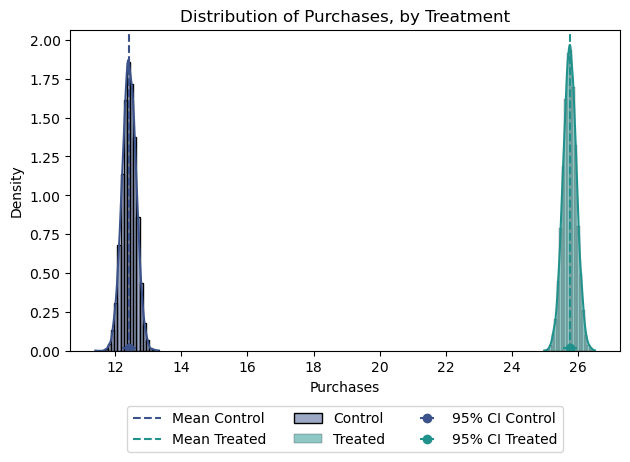

In [39]:
#| label: fig-ate-dist0
#| fig-cap: Purchase Distribution, by Treatment
#| code-fold: true
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Control vs Treated
df_control = df[df['treat'] == 'control']
df_treated = df[df['treat'] == 'treated']

# Calculate mean and standard error for email_A and email_B
mean_open_A = df_control['purch'].mean()
std_error_A = df_control['purch'].std() / np.sqrt(len(df_control))

mean_open_B = df_treated['purch'].mean()
std_error_B = df_treated['purch'].std() / np.sqrt(len(df_treated))

normal_data_A = np.random.normal(mean_open_A, std_error_A, 10000)
normal_data_B = np.random.normal(mean_open_B, std_error_B, 10000)

fig, axs = plt.subplots(1, 1)

sns.histplot(normal_data_A, kde=True, stat='density', label='Control', bins=20, palette='viridis')
sns.histplot(normal_data_B, kde=True, stat='density', label='Treated', bins=20, palette='viridis')

plt.xlabel('Purchases')
plt.ylabel('Density')
plt.title('Distribution of Purchases, by Treatment')
plt.axvline(mean_open_A, color=sns.color_palette()[0], linestyle='--', label='Mean Control')
plt.axvline(mean_open_B, color=sns.color_palette()[1], linestyle='--', label='Mean Treated')
plt.errorbar(mean_open_A, 0.02, xerr=std_error_A, fmt='o', color=sns.color_palette()[0], label='95% CI Control')
plt.errorbar(mean_open_B, 0.02, xerr=std_error_B, fmt='o', color=sns.color_palette()[1], label='95% CI Treated')
plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.15), loc='upper center') 

plt.tight_layout()
plt.show()

Again, assuming Normality, we can also estimate confidence intervals:

In [37]:
#| code-fold: true

import scipy.stats as stats

df_control = df[df['treat'] == 'control']
df_treated = df[df['treat'] == 'treated']
        
# Calculate mean and standard error for email_A and email_B
mean_open_A = df_control['purch'].mean()
std_error_A = df_control['purch'].std() / np.sqrt(len(df_control))

mean_open_B = df_treated['purch'].mean()
std_error_B = df_treated['purch'].std() / np.sqrt(len(df_treated))
    
# Calculate the confidence interval using the t-distribution
confidence_interval_A = stats.norm.interval(0.95, loc=mean_open_A, scale=std_error_A)
confidence_interval_B = stats.norm.interval(0.95, loc=mean_open_B, scale=std_error_B)

In [38]:
#| echo: false
print("Mean Response Control:", round(mean_open_A, 1))
print("Mean Response Treated:", round(mean_open_B,1))

# Format the confidence interval values
formatted_lower_bound = "{:.2f}".format(confidence_interval_A[0])
formatted_upper_bound = "{:.2f}".format(confidence_interval_A[1])
# Print the formatted confidence interval
print("95% Confidence Interval for Control: [{}, {}]".format(formatted_lower_bound, formatted_upper_bound))

# Format the confidence interval values
formatted_lower_bound = "{:.2f}".format(confidence_interval_B[0])
formatted_upper_bound = "{:.2f}".format(confidence_interval_B[1])
# Print the formatted confidence interval
print("95% Confidence Interval for Treated: [{}, {}]".format(formatted_lower_bound, formatted_upper_bound))


Mean Response Control: 12.4
Mean Response Treated: 25.7
95% Confidence Interval for Control: [12.00, 12.84]
95% Confidence Interval for Treated: [25.34, 26.15]


## 2.4. Email A vs Email B

Now, let's turn our attention to the second causal question: **Which email design, Email A or Email B, is more effective in driving engagement and sales?** 

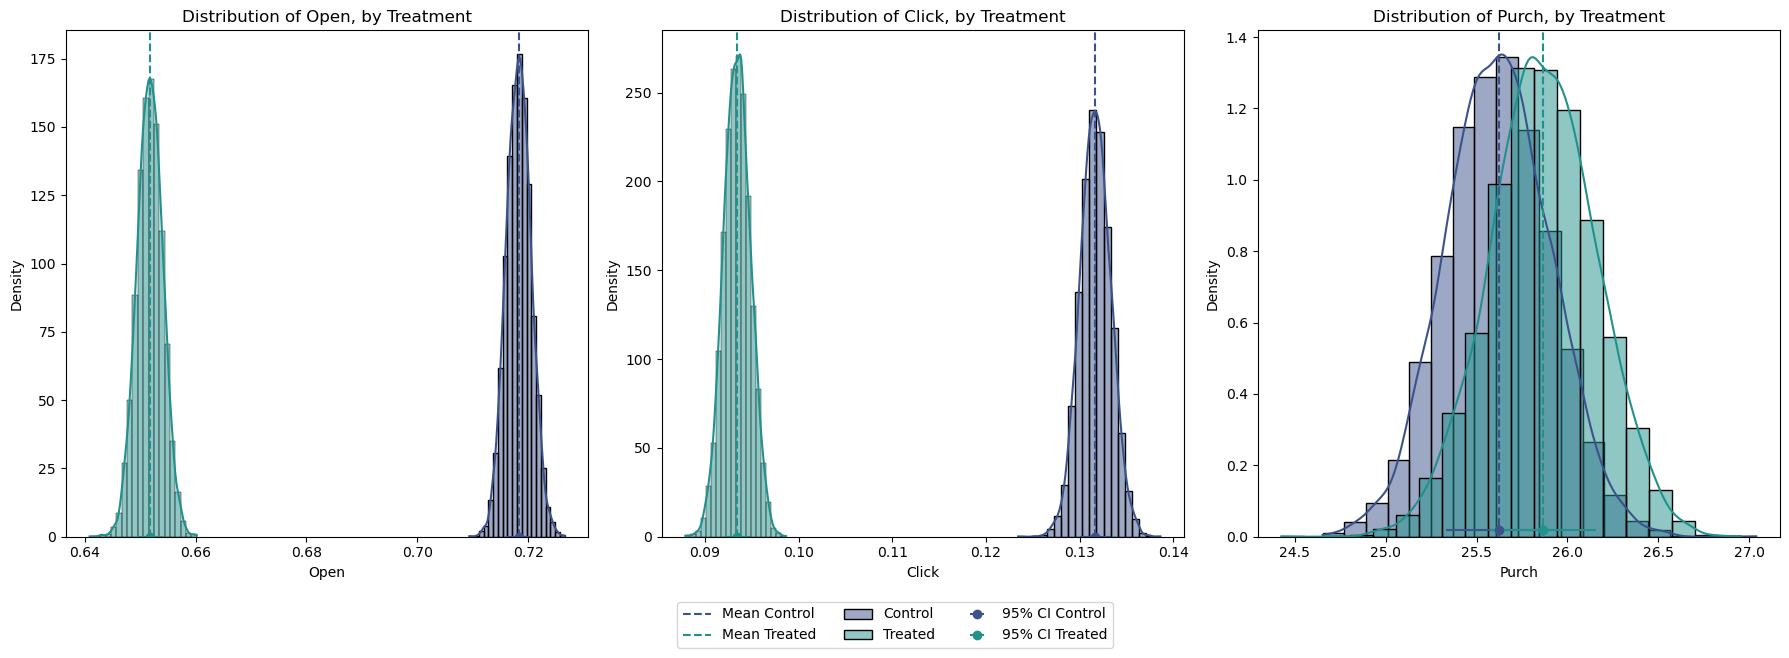

In [9]:
#| label: fig-ate-dist2
#| fig-cap: Outcome Distribution, by AB Treatment
#| code-fold: true

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_variable_comparison(df):
    variables = ['open', 'click', 'purch']

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, variable in enumerate(variables):
        # Control vs Treated
        df_control = df[df['group'] == 'email_A']
        df_treated = df[df['group'] == 'email_B']

        # Calculate mean and standard error for control and treated groups
        mean_control = df_control[variable].mean()
        std_error_control = df_control[variable].std() / np.sqrt(len(df_control))
        mean_treated = df_treated[variable].mean()
        std_error_treated = df_treated[variable].std() / np.sqrt(len(df_treated))

        # Generate normal distribution data for control and treated groups
        normal_data_control = np.random.normal(mean_control, std_error_control, 10000)
        normal_data_treated = np.random.normal(mean_treated, std_error_treated, 10000)

        # Plot histograms for control and treated groups
        sns.histplot(normal_data_control, kde=True, stat='density', label='Control', bins=20, palette='viridis', ax=axs[i])
        sns.histplot(normal_data_treated, kde=True, stat='density', label='Treated', bins=20, palette='viridis', ax=axs[i])

        # Set labels and title
        axs[i].set_xlabel(f'{variable.capitalize()}')
        axs[i].set_ylabel('Density')
        axs[i].set_title(f'Distribution of {variable.capitalize()}, by Treatment')

        # Plot mean and error bars
        axs[i].axvline(mean_control, color=sns.color_palette()[0], linestyle='--', label='Mean Control')
        axs[i].axvline(mean_treated, color=sns.color_palette()[1], linestyle='--', label='Mean Treated')
        axs[i].errorbar(mean_control, 0.02, xerr=std_error_control, fmt='o', color=sns.color_palette()[0], label='95% CI Control')
        axs[i].errorbar(mean_treated, 0.02, xerr=std_error_treated, fmt='o', color=sns.color_palette()[1], label='95% CI Treated')

        # Add legend
        #axs[i].legend(ncol=3, bbox_to_anchor=(0.5, -0.15), loc='upper center') 

    #
    handles, labels = axs[i].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.0))
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


# Example usage:
plot_variable_comparison(df)

In [5]:
#| code-fold: true

import scipy.stats as stats

df_email_A = df[df['group'] == 'email_A']
df_email_B = df[df['group'] == 'email_B']
        
# Calculate mean and standard error for email_A and email_B
mean_open_A = df_email_A['purch'].mean()
std_error_A = df_email_A['purch'].std() / np.sqrt(len(df_email_A))

mean_open_B = df_email_B['purch'].mean()
std_error_B = df_email_B['purch'].std() / np.sqrt(len(df_email_B))
    
# Calculate the confidence interval using the t-distribution
confidence_interval_A = stats.norm.interval(0.95, loc=mean_open_A, scale=std_error_A)
confidence_interval_B = stats.norm.interval(0.95, loc=mean_open_B, scale=std_error_B)

In [6]:
#| echo: false
print("Mean Response email_A:", round(mean_open_A, 1))
print("Mean Response email_B:", round(mean_open_B,1))

# Format the confidence interval values
formatted_lower_bound = "{:.2f}".format(confidence_interval_A[0])
formatted_upper_bound = "{:.2f}".format(confidence_interval_A[1])
# Print the formatted confidence interval
print("95% Confidence Interval for email_A: [{}, {}]".format(formatted_lower_bound, formatted_upper_bound))

# Format the confidence interval values
formatted_lower_bound = "{:.2f}".format(confidence_interval_B[0])
formatted_upper_bound = "{:.2f}".format(confidence_interval_B[1])
# Print the formatted confidence interval
print("95% Confidence Interval for email_B: [{}, {}]".format(formatted_lower_bound, formatted_upper_bound))

Mean Response email_A: 25.6
Mean Response email_B: 25.9
95% Confidence Interval for email_A: [25.06, 26.19]
95% Confidence Interval for email_B: [25.29, 26.44]


Interestingly enough, Email A appears to outperform Email B in terms of **opens** and **clicks** (@fig-ate-dist2). However, **this level of engagement does not necessarily translate to higher purchase rates.** Purchases from Email B are higher on average, but the large overlap in their distribution is telling us that this difference might not be significant. While purchases from Email B are higher on average, the large overlap in their distribution suggests that this difference might not be significant. 

To confirm this conclusion, we can conduct a linear regression comparing Email A and Email B purchases:

In [65]:
#| label: tbl-reg3
#| tbl-cap: A/B Regression Results III
#| code-fold: true

df_ab = df[df['group'] != 'ctrl']
smf.ols('purch ~ group', data=df_ab).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,25.6228,0.291,88.070,0.000,25.053,26.193
group[T.email_B],0.2435,0.411,0.592,0.554,-0.563,1.050


Indeed, despite observing higher purchases associated with Email B, the obtained p-value of 0.554 indicates that this difference is **not statistically significant**.

These findings show how important it is to look at different metrics and really dig into the data to figure out what's working best for engaging customers and boosting sales.

# 3. Conclusion

In this post, we've explored a variety of methods and tools used for **A/B testing analysis**, ranging from visual comparisons to statistical tests and regression analysis. Each approach offers cool insights about the quality of our randomization and also about the causal effect of our marketing campaigns.

Looking ahead, in a next article on AB testing, I'll take a deep dive into **Bayesian methods** and **nonparametric estimation** of standard errors for uncertainty. These techniques are particularly valuable when we aim to avoid assumptions about the distribution behavior, offering robust alternatives for analyzing and interpreting A/B testing results in real-world scenarios.